_Version log: Optimisation using Principle Component Analysis._

In [13]:
import sys, warnings, os, time
import CS_functions as cs
import numpy as np
from matplotlib import pyplot as plt
from scipy import linalg as spla
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category= ConvergenceWarning)
plt.rcParams.update({'font.size':16})
np.set_printoptions(threshold=sys.maxsize)

In [14]:
training_dataset = 5

training_directory = "data\\training_set{0:}\\".format(training_dataset)
training_file_paths = [os.path.join(training_directory, file_name) for file_name in os.listdir(training_directory)]

training_data = np.array([np.genfromtxt(file_path, delimiter=",", filling_values= np.nan) for file_path in training_file_paths])

training_data = np.rollaxis(training_data, -1, 0) # move the last axis to the front
training_interferograms, training_uncertainty = training_data # now we can seperate the interferograms from the uncertainties. :)

training_interferograms.shape

(900, 200)

In [15]:
interferogram_to_test = 11

test_file_name = "1dmockanderrors{0:d}".format(interferogram_to_test)

test_interferogram, test_uncertainties = cs.open_dataset(test_file_name, ".csv")

In [16]:
start_time = time.time()

number_of_pca_components = None # use `None` for all of them.

pca = PCA(n_components= number_of_pca_components)
pca.fit(training_interferograms) # is it possible to weight the datapoints using the uncertainty?

relitive_importance = pca.explained_variance_ratio_ #The most important component is first.
basis_transform = pca.components_ # components in the original basis.

sparse_interferograms = pca.transform(training_interferograms) #transform the interferograms into the sparse basis
test_in_new_basis = pca.transform(test_interferogram[None, :])

# Reconstruct original data
recovered_interferogram = pca.inverse_transform(test_in_new_basis)[0]
recovered_interferogram2 = np.matmul(test_in_new_basis, basis_transform)[0] + pca.mean_ # like lasso, pca also normalises the data so the mean is more difficult to recover.

end_time = time.time()

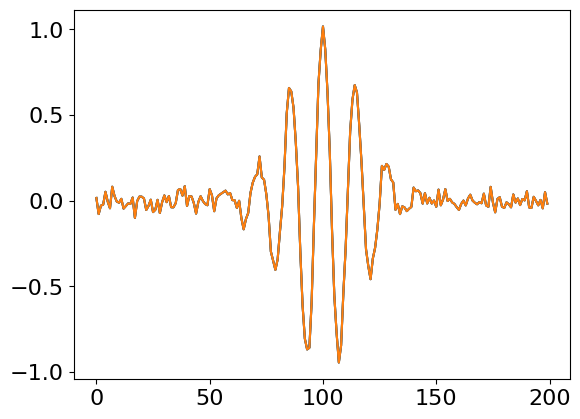

In [17]:
plt.plot(test_interferogram, color= "k")

plt.plot(recovered_interferogram)
plt.plot(recovered_interferogram2) #Should be the same

plt.show()

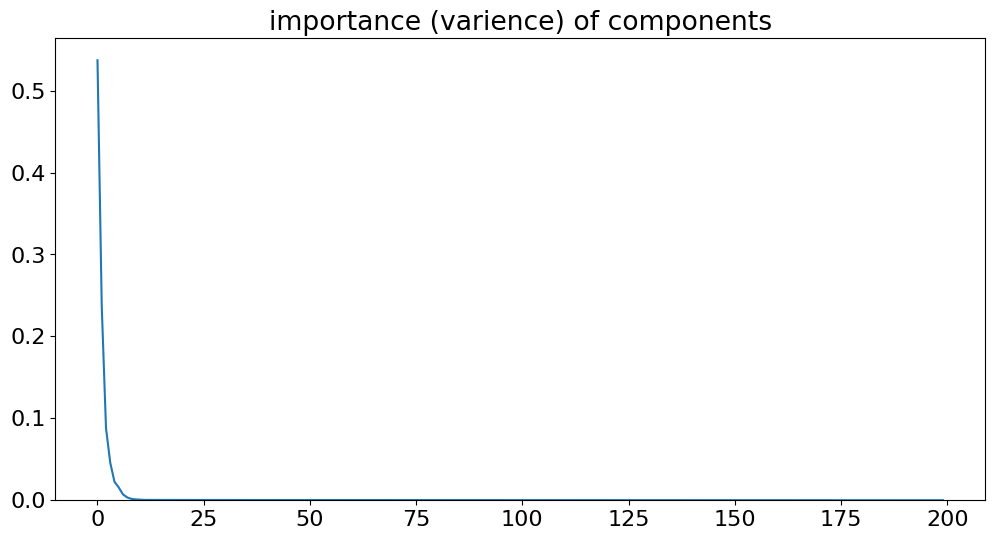

In [18]:
fig, axs = plt.subplots(1, 1, figsize= (12, 6))

axs.plot(relitive_importance)
axs.set(ylim= (0, None), title= "importance (varience) of components")

plt.show()

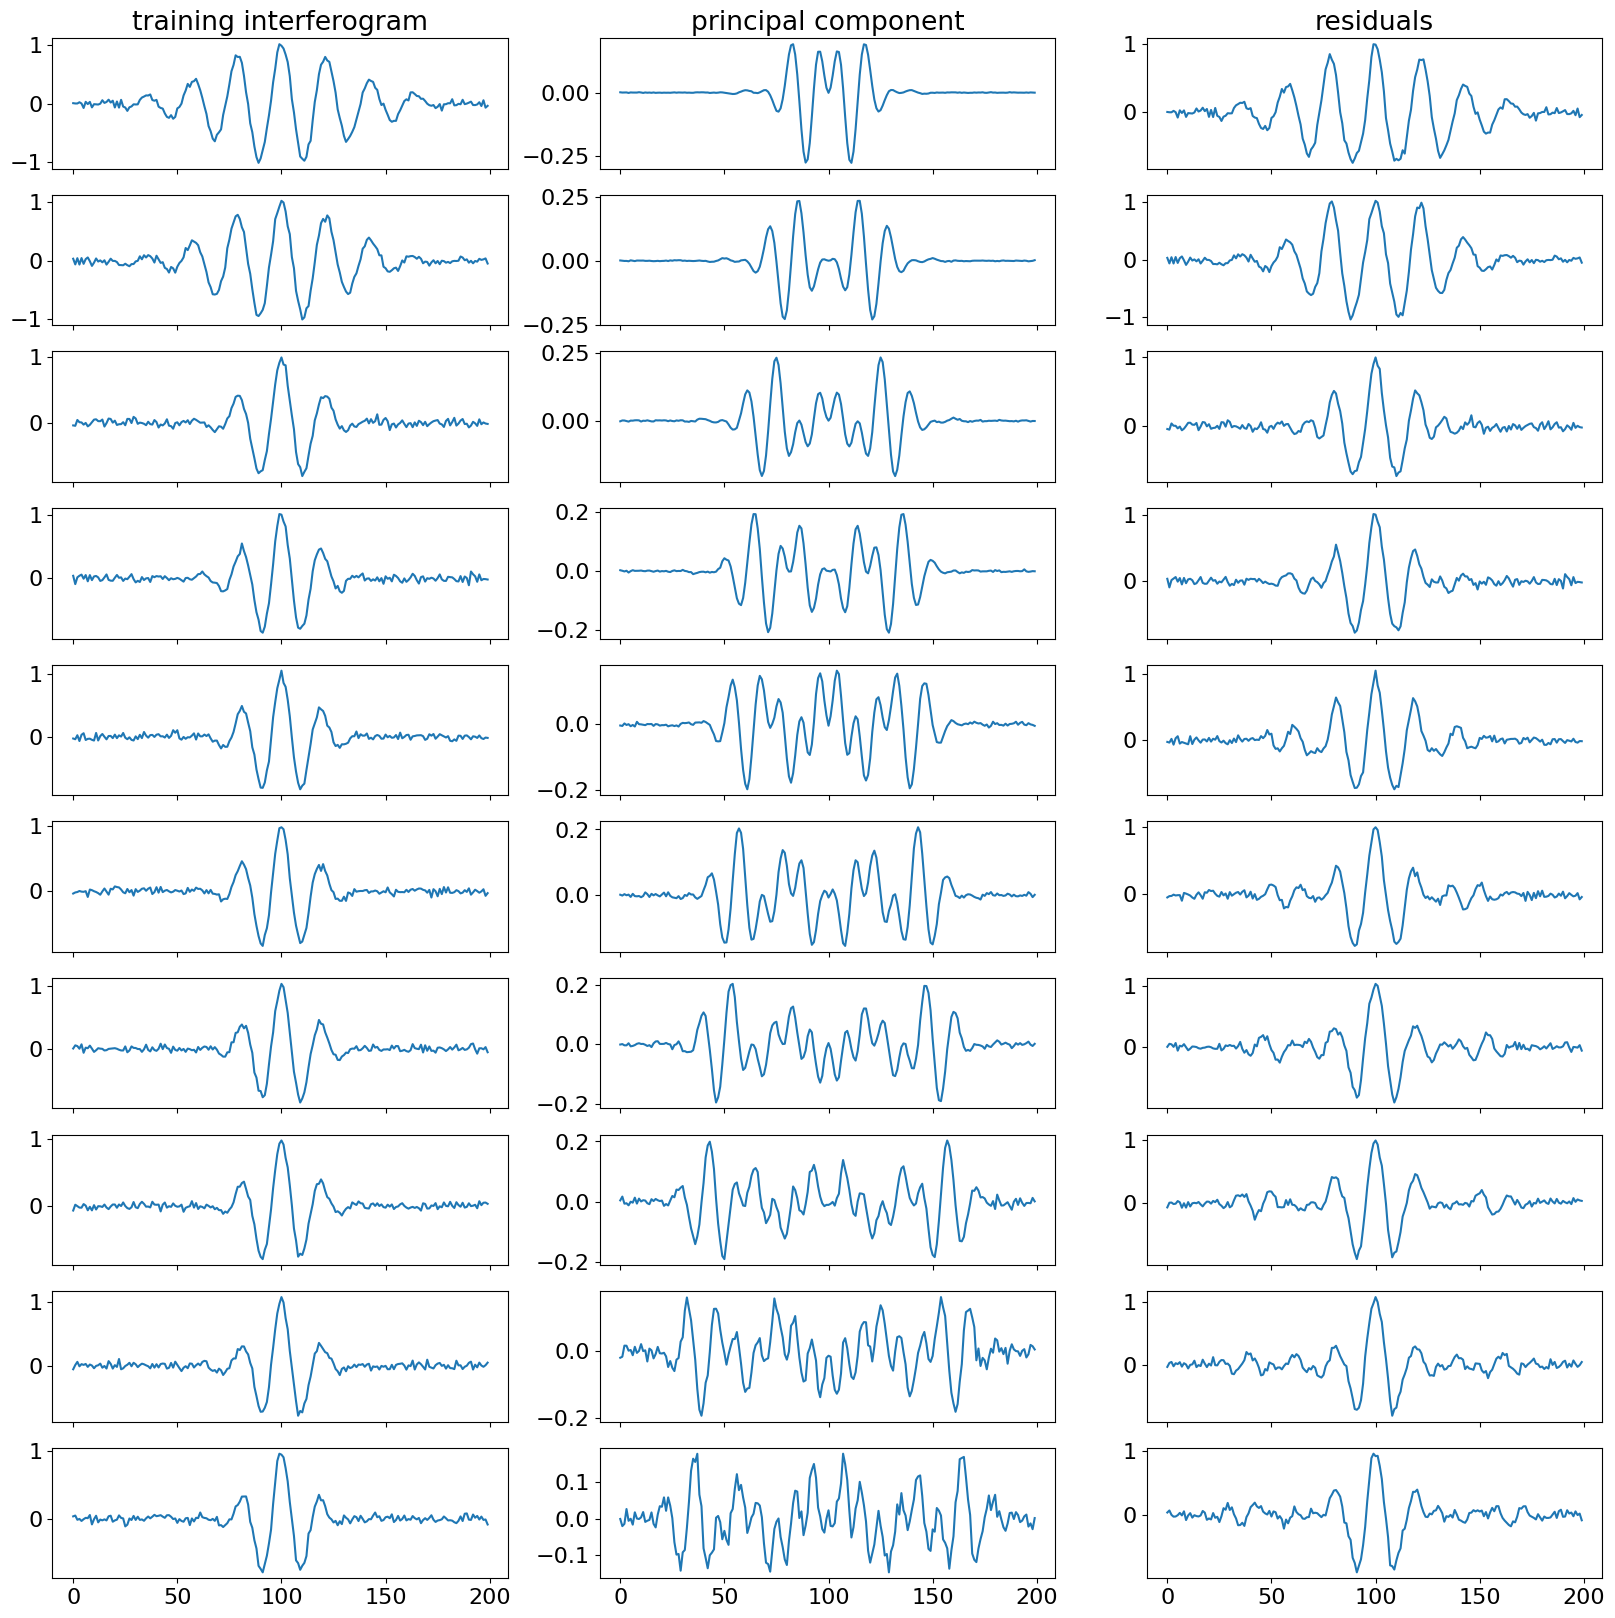

In [19]:
inds = np.arange(10) #np.random.randint(len(training_interferograms), size=10)

fig, axs = plt.subplots(len(inds), 3, figsize= (20, 2*len(inds)), sharex= True)

axs[0,0].set(title= "training interferogram")
axs[0,1].set(title= "principal component")
axs[0,2].set(title= "residuals")

for ax_row, k in zip(axs, inds):
    ax_row[0].plot(training_interferograms[k])

    ax_row[1].plot(basis_transform[k])

    ax_row[2].plot(training_interferograms[k] -basis_transform[k])

plt.show()

In [20]:
start_time2 = time.time()

# Compute QR factorization with column pivoting
Q, R, permutation_matrix = spla.qr(basis_transform, pivoting= True)

# P is the permutation matrix
print("Permutation Matrix (P):")
print(permutation_matrix)


Permutation Matrix (P):
[  0   2 114 124 198   7  18  58  72  94 100 144  42  50 156 161  87  90
  34  48  49  57 196  73  79 149  38  80  96 166  53   5  64  83  99  65
 115 140 182   4  69 116   8 125 186  21 136 152  89 130 133 181 185  77
  41 118 122 174 184 191 131 132 151 163  17 134  11 195  10  67 197  88
 102 104  51 106  54  20  46 147 160  45  59  33 105 108 110  36 119 120
  56  35 138 142 145  24 169 178 179 183  31 193  55  19 123  43  60  95
  25 154  14  29 168 176  40 199 117 103 135  78 137  93 143 107 153  27
 164 165 112  98 189 190 194  13  92  66  85 150  86 159 127 113  75 101
  61   1 146  76 109  84 162  63 111 167  28  81  74  52  82 192  71  23
 171 175 177  44 139  32  12 170 141 129   6  37 187 188 158  22  26 173
 155 148  47   3 157  62  30 121  97 172 128 180 126  70  16   9  15  39
  68  91]


In [21]:
number_of_detectors = 8
regularization_coeffient = 1e-3

detectors = permutation_matrix[:number_of_detectors]

end_time2 = time.time()

print(end_time +end_time2 -start_time -start_time2)
print(*np.sort(detectors), sep= ",")

0.31630373001098633
0,2,7,18,58,114,124,198


In [22]:
samples = test_interferogram[detectors]
measurement_matrix = basis_transform[:,detectors]
mean = np.mean(samples)

lasso = Lasso(alpha= regularization_coeffient)
lasso.fit(measurement_matrix.T, samples)

result = np.matmul(basis_transform.T, lasso.coef_) +mean

In [23]:
samples_with_gaps = np.full_like(test_interferogram, np.nan)
samples_with_gaps[detectors] = test_interferogram[detectors]
result2 = cs.compressed_sensing(samples_with_gaps, regularization_coeffient)

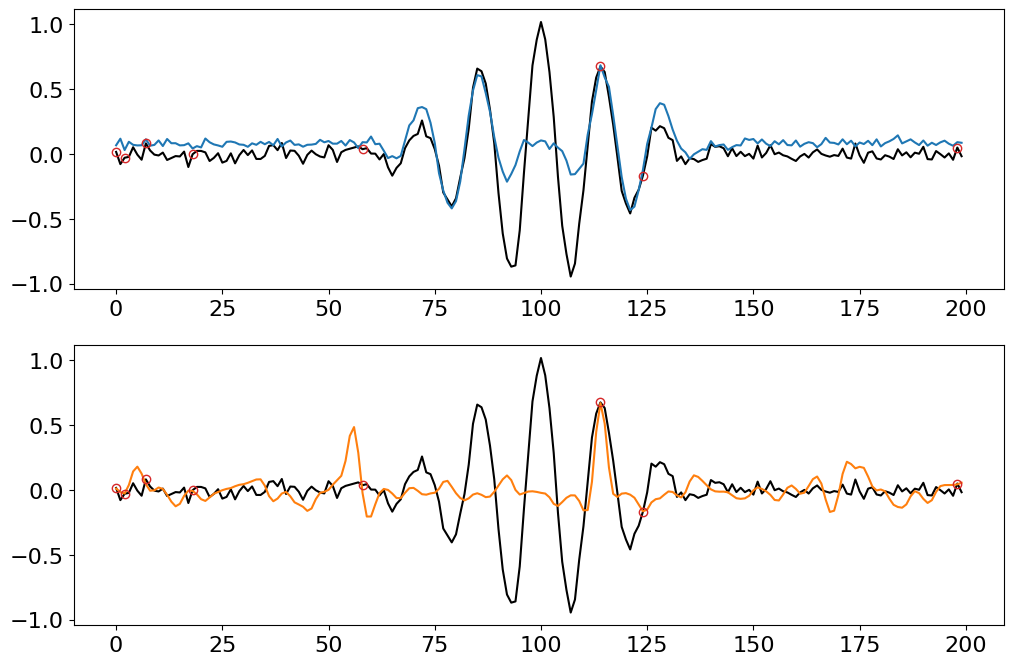

In [24]:
fig, axs = plt.subplots(2, 1, figsize= (12, 8))

axs[0].plot(test_interferogram, color= "k")
axs[0].plot(result, color= "tab:blue")
axs[0].plot(detectors, test_interferogram[detectors], color= "tab:red", marker= "o", linestyle= "none", markerfacecolor= "none")

axs[1].plot(test_interferogram, color= "k")
axs[1].plot(result2, color= "tab:orange")
axs[1].plot(detectors, test_interferogram[detectors], color= "tab:red", marker= "o", linestyle= "none", markerfacecolor= "none")

plt.show()